In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import re
import hashlib
%matplotlib inline

In [2]:
BASE_TRAIN_FOLDER_WAV = "wav_data/train/audio/"
BASE_TRAIN_FOLDER_SPEC = "spectrograms/"
RANDOM_EXAMPLE_FILE = "wav_data/train/audio/no/1706c35f_nohash_0.wav"

In [3]:
# From dataset README.
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name.encode()).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    
    if percentage_hash < validation_percentage:
        return 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        return 'testing'
    return 'train'

In [4]:
def wav2spec(wav_path, sample_rate=16000, use_log=False, use_mel=False, should_plot=False):
    samples, sample_rate = librosa.load(wav_path, sr=sample_rate)
    #sample_rate, samples = wavfile.read(wav_path)
    
    if len(samples) < sample_rate:
        samples = np.pad(samples, (0, sample_rate - len(samples)), mode='linear_ramp')
    
    spec = np.abs(librosa.stft(samples))

    if use_log:
        spec = librosa.amplitude_to_db(spec, ref=np.max)
    
    if use_mel:
        spec = librosa.feature.melspectrogram(S=spec)
        
    if should_plot:
        sns.heatmap(spec)
        plt.show()
    
    #freq, times, spectrogram = signal.spectrogram(samples, sample_rate)
    return sample_rate, samples, spec

# Exploration du dataset

## Description générale du dataset
~66,000 fichiers de 1 seconde

### Nombre de représentants par classe

In [5]:
repartition = []
for label in os.listdir(BASE_TRAIN_FOLDER_WAV):
    repartition += [label] * len(os.listdir(os.path.join(BASE_TRAIN_FOLDER_WAV, label)))

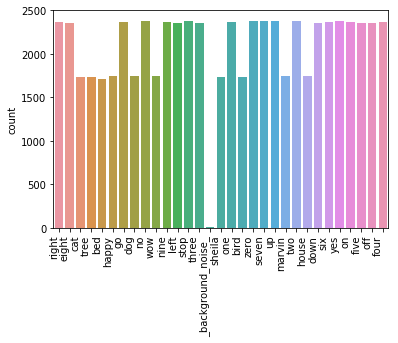

In [6]:
ax = sns.countplot(repartition)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

Les classes sont relativement équilibrées

### Cas particulier du "Background noise"
Un seul fichier long, à découper nous-même

In [11]:
background_noise_folder = os.path.join(BASE_TRAIN_FOLDER_WAV, '_background_noise_')
silence_folder = os.path.join(BASE_TRAIN_FOLDER_WAV, 'silence')
os.makedirs(silence_folder, exist_ok=True)
counter = 0
for filename in os.listdir(background_noise_folder):
    if not filename.endswith(".wav"):
        continue
    sample_rate, samples = wavfile.read(os.path.join(background_noise_folder, filename))
    for i in range(0, len(samples), sample_rate):
        part = samples[i:i+sample_rate]
        out_filename = os.path.join(silence_folder, f"{filename}_nohash_{i}.wav")
        wavfile.write(out_filename, sample_rate, part)
        counter += 1
print(f"Created {counter} silence files")

Created 402 silence files


Note : ~6 fois moins de fichiers que pour les autres classes, il pourrait être intéressant de générer plus de fichiers de "silence"

#### Data synthesis [TODO]

On découpe, change le pitch, deforme etc les background noise pour générer 2000 secondes et équilibrer les classes

#### Data mining [TODO]

On récupère plus de background noise sur l'internet

### Visualisation d'un exemple
WAV puis spectrogram

In [7]:
samples = librosa.load(RANDOM_EXAMPLE_FILE, sr=16000)[0]

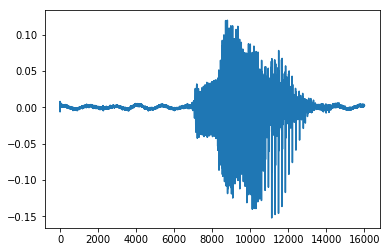

In [8]:
sns.lineplot(x=range(16000), y=samples)

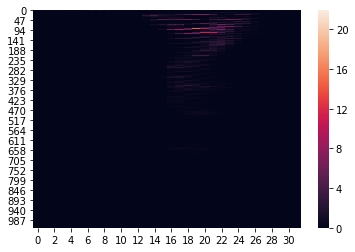

In [9]:
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True);

## Preprocessing

### Plusieurs types de spectrograms

Image plus caractéristique pour le "Mel power spectrogram" et l'application du log (plus proche du fonctionnement de l'oreille humaine)

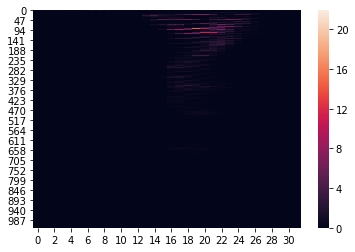

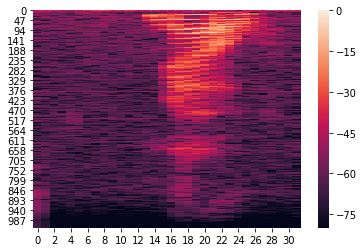

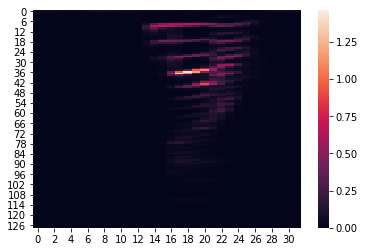

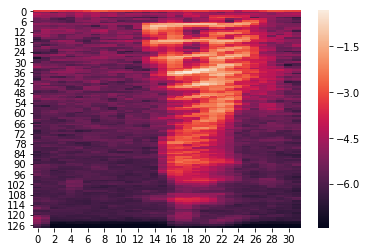

In [10]:
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True);
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True, use_log=True);
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True, use_mel=True);
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True, use_log=True, use_mel=True);

### Resampling
Comparaison d'audio avant et après resampling

In [11]:
samples16000 = librosa.load(RANDOM_EXAMPLE_FILE, sr=16000)[0]
ipd.Audio(samples16000, rate=16000)

In [12]:
samples8000 = librosa.load(RANDOM_EXAMPLE_FILE, sr=8000)[0]
ipd.Audio(samples8000, rate=8000)

Les deux sont tout aussi compréhensibles, la différence est minime, mais le poids est divisé par deux.

Comparaison des spectrograms après resampling

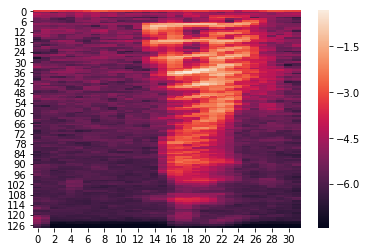

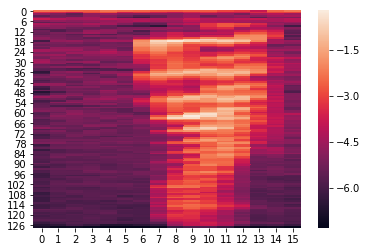

In [13]:
wav2spec(RANDOM_EXAMPLE_FILE, sample_rate=16000, should_plot=True, use_log=True, use_mel=True);
wav2spec(RANDOM_EXAMPLE_FILE, sample_rate=8000, should_plot=True, use_log=True, use_mel=True);

# Pre-processing du dataset

On choisit :
- taille des données ?
- mel-log-spectrogram
- normalisation du volume
- suppression du bruit + padding 
- data de synthèse ?
- resampling à 8k au lieu de 16k ? (suppression de bruit et données plus légères)

Pour chacun des x labels, on créé un array numpy en 3D : nombre de samples dans le dataset, frequence (=129), temps (=71)

In [14]:
RESAMPLE_RATE = 8000
USE_LOG = True
USE_MEL = True

In [15]:
SPEC_SHAPE = wav2spec(RANDOM_EXAMPLE_FILE, sample_rate=RESAMPLE_RATE, use_log=USE_LOG, use_mel=USE_MEL)[2].shape

In [16]:
SPEC_SHAPE

(128, 16)

In [21]:
def generate_subset(set_name, label, validation_percentage=10, testing_percentage=0):
    label_folder_wav = os.path.join(BASE_TRAIN_FOLDER_WAV, label)
    os.makedirs(os.path.join(BASE_TRAIN_FOLDER_SPEC, set_name), exist_ok=True)
    label_files = [
        filename for filename in os.listdir(label_folder_wav) 
        if filename.endswith('.wav') and which_set(filename, validation_percentage, testing_percentage) == set_name
    ]
    
    label_specs = np.zeros((len(label_files), *SPEC_SHAPE), dtype=np.float16)
    for i, filename in tqdm(enumerate(label_files), desc=f"{label} ({set_name})"):
        sample_rate, samples, spectrogram = wav2spec(
            os.path.join(label_folder_wav, filename), 
            sample_rate=RESAMPLE_RATE, 
            use_log=USE_LOG, 
            use_mel=USE_MEL
        )
        label_specs[i,:,:] = spectrogram.astype(np.float16)  # using float16 saves a lot of space (-75%)
    np.save(os.path.join(BASE_TRAIN_FOLDER_SPEC, set_name, label), label_specs)

In [22]:
for label in os.listdir(BASE_TRAIN_FOLDER_WAV):
    if label.startswith('.') or label.startswith('_'):
        print(f"Ignoring folder '{label}'")
        continue
    
    generate_subset('train', label)
    generate_subset('validation', label)

right (train): 2111it [01:09, 30.39it/s]
right (validation): 256it [00:09, 26.86it/s]
eight (train): 2109it [01:19, 26.67it/s]
eight (validation): 243it [00:08, 27.86it/s]
cat (train): 1565it [00:57, 27.03it/s]
cat (validation): 168it [00:05, 26.26it/s]
tree (train): 1567it [00:50, 30.76it/s]
tree (validation): 166it [00:05, 30.56it/s]
bed (train): 1516it [00:55, 27.47it/s]
bed (validation): 197it [00:08, 22.56it/s]
happy (train): 1553it [00:52, 29.51it/s]
happy (validation): 189it [00:06, 32.19it/s]
go (train): 2112it [01:21, 25.81it/s]
go (validation): 260it [00:08, 30.32it/s]
dog (train): 1576it [00:57, 27.46it/s]
dog (validation): 170it [00:05, 31.13it/s]
no (train): 2105it [01:08, 31.20it/s]
no (validation): 270it [00:08, 31.18it/s]
wow (train): 1579it [00:50, 32.34it/s]
wow (validation): 166it [00:05, 32.77it/s]
nine (train): 2134it [01:14, 28.76it/s]
nine (validation): 230it [00:07, 29.19it/s]
left (train): 2106it [01:17, 27.15it/s]
left (validation): 247it [00:08, 29.24it/s]
st

Ignoring folder '_background_noise_'


sheila (train): 1558it [00:53, 29.22it/s]
sheila (validation): 176it [00:06, 27.44it/s]
one (train): 2140it [01:06, 32.05it/s]
one (validation): 230it [00:07, 31.32it/s]
bird (train): 1569it [01:03, 24.83it/s]
bird (validation): 162it [00:05, 24.59it/s]
zero (train): 2116it [01:18, 26.91it/s]
zero (validation): 260it [00:08, 24.56it/s]
seven (train): 2114it [01:10, 27.79it/s]
seven (validation): 263it [00:08, 31.15it/s]
up (train): 2115it [01:16, 27.82it/s]
up (validation): 260it [00:08, 31.83it/s]
marvin (train): 1586it [00:51, 30.83it/s]
marvin (validation): 160it [00:05, 27.74it/s]
two (train): 2137it [01:19, 26.79it/s]
two (validation): 236it [00:09, 25.12it/s]
house (train): 1577it [01:04, 24.39it/s]
house (validation): 173it [00:07, 23.06it/s]
down (train): 2095it [01:22, 25.39it/s]
down (validation): 264it [00:09, 26.92it/s]
six (train): 2107it [01:36, 21.88it/s]
six (validation): 262it [00:13, 23.96it/s]
yes (train): 2116it [01:39, 21.37it/s]
yes (validation): 261it [00:09, 28.